# Compute the formation efficiency for all variations we explored

Split by stable mass transfer channel vs CE channel
and by BBH/BHNS/NSNS

In [12]:
import numpy as np
import os 
import sys
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.lines as mlines
import multiprocessing as mp


# add run_data path to sys
sys.path.append('./run_data')
from definitions import sim_flags_dict

home_dir    = os.path.expanduser("~") 
compas_v    = "v03.01.02" #"v02.46.01" # #"#v02.35.02/"
datar_root  =  f"{home_dir}/ceph/CompasOutput/{compas_v}/"


## Read the potential DCO data 
this table includes all systems that become a DCO at any Z (i.e. more info than just the DCO data)

### and subdivide by DCO flavour


In [3]:
    
def get_merging_dcos(sim_name =  'NewWinds_RemFryer2012', prog_table_name = 'potential_DCO_progenitors_Allinfo.h5'):
    """Read in the potential DCO progenitor table and return the tables for BBH, BHNS and NSNS mergers

    Args:
        sim_name (str, optional): which simulation to load Default 'NewWinds_RemFryer2012'.
        prog_table_name (str, optional): 'potential_DCO_progenitors_Allinfo.h5'.

    Returns:
        BBH_progenitors, BHNS_progenitors, NSNS_progenitors: pandas tables containing the progenitors of BBH, BHNS and NSNS mergers
    """
    ####################################
    # Take the base potential DCO progenitor table
    if os.path.isfile(datar_root+ f'/{sim_name}/'+prog_table_name):
        potential_DCO_progenitors = pd.read_hdf(datar_root + f'{sim_name}/' + prog_table_name, key='All_DCO')
        print('Table exists, reading in... ' ) #potential_DCO_progenitors.info()
    else:
        print('error, table doesnt exist, you should make it using "DataManipulation.ipynb" first')

    potential_DCO_progenitors.reset_index(drop=True, inplace=True)

    # Also make tables that contain only the actual BBH, BHNS and NSNS mergers
    def DCO_merger_bool(table, flavor = 'BBH'):
        """return the DCO merger bool for a given flavor

        Args:
            pandas table: containing all potential DCOs (incl. things that don't become DCO at specific Z)
            flavor (str, optional): BBH, BHNS, or NSNS 
        """
        BBH_bool = np.logical_and(table['Stellar_Type(1)'] == 14,table['Stellar_Type(2)'] == 14)
        BHNS_bool = np.logical_or(np.logical_and(table['Stellar_Type(1)'] == 13,table['Stellar_Type(2)'] == 14),
                                np.logical_and(table['Stellar_Type(1)'] == 14,table['Stellar_Type(2)'] == 13) )
        NSNS_bool = np.logical_and(table['Stellar_Type(1)'] == 13,table['Stellar_Type(2)'] == 13)
        if flavor == 'BBH':
            return np.logical_and(BBH_bool,table['Merges_Hubble_Time'] == True)
        elif flavor == 'BHNS':  
            return np.logical_and(BHNS_bool,table['Merges_Hubble_Time'] == True)
        elif flavor == 'NSNS':
            return np.logical_and(NSNS_bool,table['Merges_Hubble_Time'] == True)

    # make the tables for every flavour
    merging_BBH_bool  = DCO_merger_bool(potential_DCO_progenitors, flavor = 'BBH')
    BBH_progenitors  = potential_DCO_progenitors[merging_BBH_bool]

    merging_BHNS_bool  = DCO_merger_bool(potential_DCO_progenitors, flavor = 'BHNS')
    BHNS_progenitors = potential_DCO_progenitors[merging_BHNS_bool]

    merging_NSNS_bool  = DCO_merger_bool(potential_DCO_progenitors, flavor = 'NSNS')
    NSNS_progenitors = potential_DCO_progenitors[merging_NSNS_bool]

    return [BBH_progenitors, BHNS_progenitors, NSNS_progenitors]





# Compute the 'total mass evolved per Z'

In [4]:

def totalMassEvolvedPerZ(pathCOMPASh5, x1=0.01, x2=0.08, x3=0.5, x4=200., a1=-0.3, a2=-1.3, a3=-2.3, C1=1.,
                         binaryFraction=1, Mmin_universe=0.01, Mmax_universe=200., sampleSize=2000000):
    """_summary_

    Args:
        # COMPAS simulation parameters
        pathCOMPASh5 (_type_, optional): path to your COMPAS file. Defaults to None.

        # Broken powerlaw (Kroupa IMF) parameters
        x1, x2, x3, x4: float, the break points (mass ranges) for the three segments
        a1, a2, a3: float, the power law indices 
        <0.01 - 0.08> a = -0.3, <0.08 - 0.5> a = -1.3, <0.5 - 200> a = -2.3
        C1: float, the normalization constant for the first segment
        
        # Believes about star formation in the Universe
        binaryFraction (int, optional): What fraction of stars are in binaries. Default= 1.
        Mmin_universe, Mmax_universe (float): the min and max mass that stars in the Universe can be born with  Defaults: 0.01 and 200.

    Returns:
        _type_: _description_
    """ 
    # Open the COMPAS file
    COMPASdataf = h5.File(pathCOMPASh5, 'r')

    # Min and max M sampled in your COMPAS simulation.
    COMPAS_m1       = COMPASdataf['BSE_System_Parameters']['Mass@ZAMS(1)'][()]
    Mlower_COMPAS   = np.min(COMPAS_m1)
    Mupper_COMPAS   = np.max(COMPAS_m1)

    ##########################
    # Create Sample Universe 
    ##########################
    # we will use 'inverse transform sampling method' to sample our sample Universe from the IMF

    ### Primary mass
    # first we compute the y-values of the CDF of our IMF at Mmin_universe and Mmax_universe
    # Mmin_universe and Mmax_universe have to be between x1 and x4
    CDFmin = CDFbrokenPowerLaw(np.array([Mmin_universe]), x1, x2, x3, x4, a1, a2, a3, C1)
    CDFmax = CDFbrokenPowerLaw(np.array([Mmax_universe]), x1, x2, x3, x4, a1, a2, a3, C1)

    # Now we can sample Uniformly from the CDF between CDFmin and CDFmax
    drawM1      = np.random.uniform(CDFmin,CDFmax,sampleSize)
    # Convert CDF values back to masses
    M1          = invertCDFbrokenPowerLaw(drawM1, x1, x2, x3, x4, a1, a2, a3, C1)

    ### Binary fraction
    # we want that binaryFraction of the stars are in binaries
    # Hence by drawing between 0-1, we have to throw out everything that is above binaryFraction (i.e. = single and m2 = 0)
    # ! NOTE that this assumes that the binary Fraction is mass indepent! > Future work to implenet Max Moe ps and qs options
    drawBinary      = np.random.uniform(0,1,sampleSize)
    maskBinary      = drawBinary < binaryFraction  #booleans

    ### Secondary mass
    # mass ratio (q = m2/m1) distribution is assumed to be flat 
    # so then the drawM2 (if it is in a binary) just becomes the mass fraction.
    drawM2          = np.random.uniform(0,1,sampleSize)    # we are actually sampling q
    M2              = np.zeros(sampleSize)                 #
    M2[maskBinary]  = drawM2[maskBinary] * M1[maskBinary]  # = q * m1, all the ones outside the mask remain zero
    
    totalMassInStarFormation = np.sum(M1) + np.sum(M2)

    ##########################
    # Select what lies in the range of COMPAS
    ##########################
    # mask M1 and M2 to see what lies in the range of COMPAS
    maskM1          = (M1>=Mlower_COMPAS) & (M1<=Mupper_COMPAS)
    maskBinaries    = (M2!=0)
    mask_COMPAS     = maskM1 & maskBinaries

    totalMassEvolvedCOMPAS = np.sum(M1[mask_COMPAS]) + np.sum(M2[mask_COMPAS])

    ##########################
    # Finally compute the tot mass evolved per Z
    ##########################
    
    # load a bit more COMPAS data
    COMPAS_m2       = COMPASdataf['BSE_System_Parameters']['Mass@ZAMS(2)'][()]
    COMPAS_metals   = COMPASdataf['BSE_System_Parameters']['Metallicity@ZAMS(1)'][()]
    uniqueZ_COMPAS  = np.unique(COMPAS_metals)
    
    # Determine if your samples are weighted
    boolWeighted = 'mixture_weight' in COMPASdataf['BSE_System_Parameters'].keys()

    # I assume that if you have more than 100 metallicities, it's not discrete, but a continuous Z distribution
    if boolWeighted or len(uniqueZ_COMPAS) > 100: # samples are weighted we can't just add M1 + M2 from simulation # //floor
        print('using weighted samples')
        NbinariesEvolvedPerZ = []                                                           # Nbinaries simulated per Z //floor
        for Z in uniqueZ_COMPAS:
            mask = COMPAS_metals == Z
            Nbinaries = len(COMPAS_m1[mask])
            NbinariesEvolvedPerZ.append(Nbinaries)
        NbinariesEvolvedPerZ        = np.array(NbinariesEvolvedPerZ)
        AverageMassPerBinaryCOMPAS  = totalMassEvolvedCOMPAS / len(M1[mask_COMPAS])         # average mass of a binary in COMPAS simulation  //floor
        MassEvolvedPerZ             = AverageMassPerBinaryCOMPAS * NbinariesEvolvedPerZ     # //floor    

    else: # Simulation with discrete metallicities
        print('using discrete metallicities')
        total = []
        for Z in uniqueZ_COMPAS:
            Zmask = COMPAS_metals == Z
            total.append( np.sum(COMPAS_m1[Zmask]) + np.sum(COMPAS_m2[Zmask]) )

        MassEvolvedPerZ  = np.array(total)

    # fraction of total universe that was sampled by COMPAS
    fraction = totalMassEvolvedCOMPAS/float(totalMassInStarFormation)

    # We need to muliply the mass evolved per metallicity times (1/fraction) to know the total mass evolved per metallicity
    totalMassEvolvedPerMetallicity = (MassEvolvedPerZ)/(fraction)

    return totalMassEvolvedPerMetallicity


def CDFbrokenPowerLaw(x, x1=0.01, x2=0.08, x3=0.5, x4=200, a1=-0.3, a2=-1.3, a3=-2.3, C1=1):
    """
    CDF values of a three-part broken powerlaw representing a Kroupa IMF by default.
    
    Parameters:
    x: array-like, the input values
    x1, x2, x3, x4: float, the break points (mass ranges) for the three segments
    a1, a2, a3: float, the power law indices 
    C1: float, the normalization constant for the first segment
    
    Returns:
    yvalues: array-like, the output values of the CDF
    """
    
    # Initialize the output array
    yvalues = np.zeros(len(x))
    
    # Calculate the normalization constants for the other segments
    # Ensuring that the next segments start where the previous segment ends
    C2 = float(C1 * (x2**(a1-a2)))
    C3 = float(C2 * (x3**(a2-a3)))
    
    # Calculate the normalization factors for the three segments
    N1 = float(((1./(a1+1)) * C1 * (x2**(a1+1))) - ((1./(a1+1)) * C1 * (x1**(a1+1))))
    N2 = float(((1./(a2+1)) * C2 * (x3**(a2+1))) - ((1./(a2+1)) * C2 * (x2**(a2+1))))
    N3 = float(((1./(a3+1)) * C3 * (x4**(a3+1))) - ((1./(a3+1)) * C3 * (x3**(a3+1))))
    
    # Calculate the denominator of the CDF
    bottom = N1+N2+N3
    
    # Calculate the CDF values for x range: x1<=x<x2
    mask1 = (x>=x1) & (x<x2)
    top1 = ( (1./(a1+1) ) * C1 * (x[mask1]**(a1+1) ) - (1./(a1+1) ) * C1 * (x1**(a1+1) ) ) 
    yvalues[mask1] = top1/bottom
    
    # Calculate the CDF values for x range: x2<=x<x3
    mask2 = (x>=x2) & (x<x3)
    top2 =  N1 + ( (1./(a2+1) ) * C2 * (x[mask2]**(a2+1) ) - (1./(a2+1)) * C2 * (x2**(a2+1) ) ) 
    yvalues[mask2] = top2/bottom
    
    # Calculate the CDF values for x range: x3<=x<=x4
    mask3 = (x>=x3) & (x<=x4)
    top3 =  N1 + N2 + ( (1./(a3+1)) * C3 * (x[mask3]**(a3+1)) - (1./(a3+1)) * C3 * (x3**(a3+1) ) )
    yvalues[mask3] = top3/bottom
    
    return yvalues


def invertCDFbrokenPowerLaw(CDF, x1, x2, x3, x4, a1, a2, a3, C1):
    """
    Invert y-values of a CDF back to x-vals (i.e. the masses)
    Specifically for a three-part piece-wise powerlaw representing a Kroupa IMF by default. 

    Parameters:
    CDF: array-like, the CDF values to invert
    x1, x2, x3, x4: float, the break points (ranges) for the three segments
    a1, a2, a3: float, the power law indices for the three segments
    C1: float, the normalization constant for the first segment

    Returns:
    xvalues: array-like, the inverted CDF values
    """
    
    # Calculate the normalization constants for the second and third segments
    C2 = float(C1 * (x2**(a1-a2)))
    C3 = float(C2 * (x3**(a2-a3)))
    
    # Calculate the area under the curve for each segment
    N1 = float(((1./(a1+1)) * C1 * (x2**(a1+1))) - ((1./(a1+1)) * C1 * (x1**(a1+1))))
    N2 = float(((1./(a2+1)) * C2 * (x3**(a2+1))) - ((1./(a2+1)) * C2 * (x2**(a2+1))))
    N3 = float(((1./(a3+1)) * C3 * (x4**(a3+1))) - ((1./(a3+1)) * C3 * (x3**(a3+1))))
    
    # Calculate the CDF values at the breakpoints
    CDFx2 = CDFbrokenPowerLaw(np.array([x2,x2]), x1, x2, x3, x4, a1, a2, a3, C1)[0]
    CDFx3 = CDFbrokenPowerLaw(np.array([x3,x3]), x1, x2, x3, x4, a1, a2, a3, C1)[0]

    # Initialize the output array
    xvalues = np.zeros(len(CDF))
    
    # Calculate the inverse CDF values for the first segment
    mask1 = (CDF < CDFx2)
    xvalues[mask1] =  (((CDF[mask1]*(N1+N2+N3))  + \
                      ( (1./(a1+1))*C1*(x1**(a1+1))))/((1./(a1+1))*C1))**(1./(a1+1))
    
    # Calculate the inverse CDF values for the second segment
    mask2 = (CDFx2<= CDF) & (CDF < CDFx3)
    xvalues[mask2] = ((((CDF[mask2]*(N1+N2+N3))-(N1))  + \
                      ( (1./(a2+1))*C2*(x2**(a2+1))))/((1./(a2+1))*C2))**(1./(a2+1))
    
    # Calculate the inverse CDF values for the third segment
    mask3 = (CDFx3<= CDF) 
    xvalues[mask3] = ((((CDF[mask3]*(N1+N2+N3))-(N1+N2))  + \
                      ((1./(a3+1))*C3*(x3**(a3+1))))/((1./(a3+1))*C3))**(1./(a3+1))
    
    # Return the inverse CDF values
    return xvalues


# Collect the data for all simulations

In [76]:
# Dictionary to map simulation names to labels and colors we want to use in the plots
sim_name_dict = {
    'NewWinds_RemFryer2012': ['Fiducial', '#515C5D'], 
    'OldWinds_RemFryer2012': ['Old Winds', '#02926C'],
    'NewWinds_RemMullerMandel': ['M&M remnant', '#EB9910'],
    'NewWinds_RemFryer2012_noBHkick': ['No BH kick', '#CE336A'],
    'NewWinds_RemFryer2012_noNSBHkick': ['No natal kicks', '#BE4EA8'],
    'NewWinds_RemFryer2012_noMSwinds': ['No MS winds', '#58B3F6'],
    'NewWinds_RemFryer2012_noWRwinds': ['No WR winds', '#497CFE'],
    'RemFryer2012_NOwinds': ['No winds', '#5247A6']
    }

# List of DCO flavors
DCO_flavors         = ["BBH", "BHNS", "NSNS"]

In [75]:
############################################
def collect_yield_data(sim_name):
    # collect the data
    try:
        merging_DCO_tables  = get_merging_dcos(sim_name =  sim_name, prog_table_name = 'potential_DCO_progenitors_Allinfo.h5')
    except:
        print(f"Error reading in {sim_name}, you might not have runt this sim yet?")
        return sim_name, None

    # Initialize a dictionary to store the data for this simulation
    yield_dict = {}

    # Get the total mass evolved per Z
    totalMassEvolvedPerMetallicity = totalMassEvolvedPerZ(f'{datar_root}/{sim_name}/COMPAS_Output_combinedZ.h5', sampleSize=2000000)
    yield_dict['totalMassEvolvedPerMetallicity'] = totalMassEvolvedPerMetallicity

    #########################
    # Loop over the DCO flavors
    for table, flavor in zip(merging_DCO_tables, DCO_flavors):
        print(flavor)

        # Group by metallicity
        grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

        # Get all Z values and group lengths
        Z_values = np.array([Z for Z, group in grouped_byZ])

        # Check if weighted samples
        boolWeighted = 'mixture_weight' in table.keys()

        # Store the data in the dictionary
        yield_dict[flavor] = {}

        if boolWeighted: #UNTESTED
            print('using weighted samples')
            # sum the mixture_weight column for all, CE and stable channel
            yield_dict[flavor]['All_group_lengths'] = [sum(group['mixture_weight']) for Z, group in grouped_byZ]
            yield_dict[flavor]['stable_group_lengths'] = [sum(group['mixture_weight'][group['CE_Event_Counter'] == 0]) for Z, group in grouped_byZ]
            yield_dict[flavor]['CE_group_lengths'] = [sum(group['mixture_weight'][group['CE_Event_Counter'] > 0]) for Z, group in grouped_byZ]
        else:
            # count the number of systems in each group for all, CE and stable channel
            yield_dict[flavor]['All_group_lengths'] = [len(group) for Z, group in grouped_byZ]
            yield_dict[flavor]['stable_group_lengths'] = [len(group[np.logical_and(group['CE_Event_Counter'] == 0, group['CH_on_MS(1)'] == 0) ]) for Z, group in grouped_byZ]
            yield_dict[flavor]['CHEstable_group_lengths'] = [len(group[np.logical_and(group['CE_Event_Counter'] == 0, group['CH_on_MS(1)'] == 1 ) ]) for Z, group in grouped_byZ]
            yield_dict[flavor]['CE_group_lengths'] = [len(group[np.logical_and(group['CE_Event_Counter'] > 0, group['CH_on_MS(1)'] == 0) ]) for Z, group in grouped_byZ]

        print('Number of CHE BBH megers at different Z', yield_dict[flavor]['CHEstable_group_lengths']) 
        print('Number of stable BBH megers at different Z', yield_dict[flavor]['stable_group_lengths']) 
        print('Number of common env BBH megers at different Z', yield_dict[flavor]['CE_group_lengths']) 

    
    return sim_name, yield_dict


#########################
# speed up my sending each sim to a different core
pool = mp.Pool(mp.cpu_count())
# Apply collect_yield_data to every sim_name
results = pool.map(collect_yield_data, sim_name_dict.keys()) # results is now a list of yield_data dictionaries

# Combine the results into a single dictionary
yield_data = {}
for sim_name, yield_dict in results:
    yield_data[sim_name] = yield_dict


Table exists, reading in... 
Table exists, reading in... 
Table exists, reading in... 
Table exists, reading in... 
Table exists, reading in... 
using discrete metallicities
BBH
Number of CHE BBH megers at different Z [3757, 3817, 4053, 4317, 4411, 3978, 3383, 2556, 1116, 78, 0, 0]
Number of stable BBH megers at different Z [4284, 3515, 3463, 3248, 2716, 1548, 702, 492, 319, 217, 143, 103]
Number of common env BBH megers at different Z [716, 780, 1070, 901, 558, 450, 118, 24, 4, 1, 1, 1]
BHNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [75, 76, 81, 75, 82, 72, 71, 47, 38, 26, 18, 2]
Number of common env BBH megers at different Z [151, 103, 198, 270, 268, 674, 431, 199, 149, 94, 56, 3]
NSNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Number of common env BBH megers at different Z [397, 784, 1112, 755,

In [63]:
print(yield_data['NewWinds_RemFryer2012'].keys())

print(yield_data['NewWinds_RemFryer2012']['BBH'].keys() )

dict_keys(['totalMassEvolvedPerMetallicity', 'BBH', 'BHNS', 'NSNS'])
dict_keys(['All_group_lengths', 'stable_group_lengths', 'CHEstable_group_lengths', 'CE_group_lengths'])


# Plot the formation efficiency for each flavour

/tmp/ipykernel_3307013/3215834385.py:37: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(flav_data['CHEstable_group_lengths']/totalMassEvolvedPerMetallicity), label = None , lw = 3, alpha = 1,  ls = '--', marker = '', color = color)
/tmp/ipykernel_3307013/3215834385.py:36: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(flav_data['stable_group_lengths']/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = ':', marker = '', color = color)


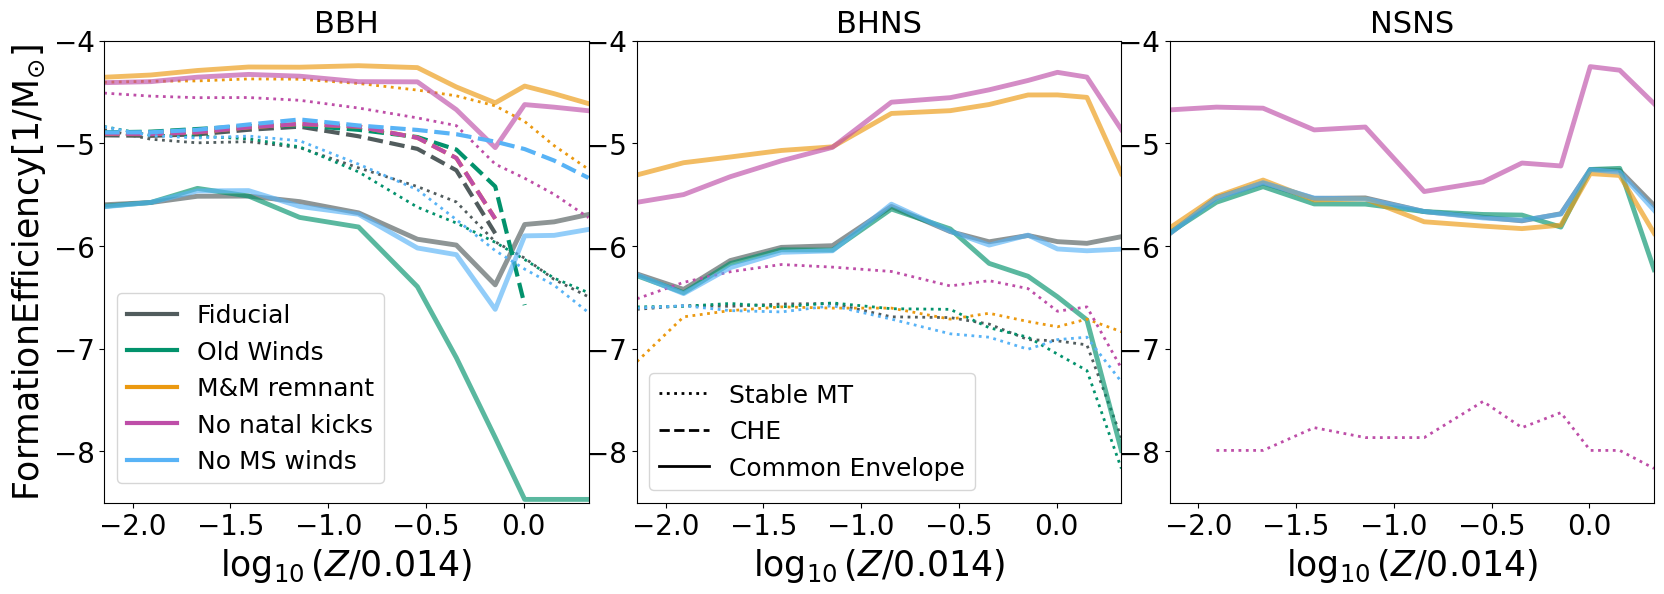

In [108]:
###########################################
# Create a figure
fig = plt.figure(figsize=(20, 6))

# Create a GridSpec with 1 row and 3 columns
gs      = GridSpec(1, 3, figure=fig)
axes    = [fig.add_subplot(gs[0, i]) for i in range(3)] # Create 3 subplots on a line

# get a list of colors
cmap = mpl.colormaps['rainbow']
colors = cmap(np.linspace(0, 1, len(sim_name_dict.keys()) ) )

#########################
# For every simulation
sim_plot_lines = [] # list to store the lines that will be added to the simulation legend
for sim_name, (label, color) in sim_name_dict.items():    

    # skip a few for clarity
    if sim_name in ['NewWinds_RemFryer2012_noWRwinds', 'RemFryer2012_NOwinds','NewWinds_RemFryer2012_noBHkick' ]: #'NewWinds_RemFryer2012_noMSwinds',
        continue

    # Create the lines that will be added to the first legend
    sim_plot_lines.append(mlines.Line2D([], [], color=color, label= label, lw = 3))

    # select the right dictionary entry
    data = yield_data[sim_name]
    totalMassEvolvedPerMetallicity = data['totalMassEvolvedPerMetallicity']

    #########################
    # Loop over the axes and DCO flavors
    for ax, flavor in zip(axes, DCO_flavors):
        # print(flavor)
        flav_data = data[flavor]

        # Plot the number of DCO mergers as a function of metallicity
        ax.plot(np.log10(Z_values/0.014), np.log10(flav_data['stable_group_lengths']/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = ':', marker = '', color = color)
        ax.plot(np.log10(Z_values/0.014), np.log10(flav_data['CHEstable_group_lengths']/totalMassEvolvedPerMetallicity), label = None , lw = 3, alpha = 1,  ls = '--', marker = '', color = color)
        ax.plot(np.log10(Z_values/0.014), np.log10(flav_data['CE_group_lengths']/totalMassEvolvedPerMetallicity), label = None, lw = 3.5, alpha = 0.65,  ls = '-',  color = color)
        # ax.plot(np.log10(Z_values/0.014), np.log10(CHECE_group_lengths/totalMassEvolvedPerMetallicity), label = f'Chem Hom. CE {sim_name}', lw = 2, ls = '--', marker = 'o', color = color)

        #####
        # plotvalues
        ax.set_title(f'{flavor}', fontsize = 22)

        ax.set_xlim(np.log10(1e-4/0.014),np.log10(0.03/0.014))
        ax.set_xlabel('$\log_{10}(Z/0.014)$', fontsize = 25)
        ax.set_ylim(-8.5,-4)
        ax.tick_params(axis='both', which='major', labelsize=20)     # increase  tick labels
        ax.tick_params(axis='both', which='minor', labelsize=20)
        

#########################
# plotvalues
fig.subplots_adjust(hspace=0.25, wspace=0.1)
axes[0].set_ylabel("$\mathrm{Formation Efficiency [1/M_{\odot}]}$", fontsize =25)

# Create the simulation legend
legend1 = axes[0].legend(handles= sim_plot_lines, bbox_to_anchor=(0, 0.48), loc='upper left', fontsize = 18, ncols = 1)
# legend1 = axes[1].legend(handles= sim_plot_lines, bbox_to_anchor=(0.5, -0.2), loc='upper center', fontsize = 18, ncols = 3)

# Creating the channel legend
stable_line = mlines.Line2D([], [],lw = 2, color='black', linestyle=':', marker = '', label='Stable MT')
CHE_line    = mlines.Line2D([], [],lw = 2, color='black', linestyle='--', marker = '', label='CHE')
CE_line     = mlines.Line2D([], [],lw = 2, color='black', linestyle='-', label='Common Envelope')
axes[1].legend(handles=[stable_line, CHE_line, CE_line], loc='lower left', fontsize = 18)

plt.savefig(f'../plots/{compas_v}/Yield_variations.pdf', bbox_inches='tight')
plt.show()


Table exists, reading in... 
using discrete metallicities
BBH
Number of CHE BBH megers at different Z [3519, 3480, 3597, 3984, 4271, 3442, 2595, 1605, 390, 0, 0, 0]
Number of stable BBH megers at different Z [3995, 3221, 2972, 3051, 2668, 1697, 1114, 789, 323, 224, 139, 94]
Number of common env BBH megers at different Z [741, 779, 897, 900, 795, 618, 342, 300, 123, 476, 505, 596]
BHNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [71, 77, 76, 80, 81, 60, 59, 51, 36, 35, 32, 4]
Number of common env BBH megers at different Z [157, 111, 212, 285, 296, 714, 406, 323, 372, 324, 312, 362]
NSNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
Number of common env BBH megers at different Z [388, 868, 1207, 855, 864, 636, 560, 517, 606, 1633, 1601, 729]


/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)
/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)
/tmp/ipykernel_3307013/527124279.py:86: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(stable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = ':', marker = '^', color = color)
/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marke

Table exists, reading in... 
using discrete metallicities
BBH
Number of CHE BBH megers at different Z [3757, 3817, 4053, 4317, 4411, 3978, 3383, 2556, 1116, 78, 0, 0]
Number of stable BBH megers at different Z [4284, 3515, 3463, 3248, 2716, 1548, 702, 492, 319, 217, 143, 103]
Number of common env BBH megers at different Z [716, 780, 1070, 901, 558, 450, 118, 24, 4, 1, 1, 1]
BHNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [75, 76, 81, 75, 82, 72, 71, 47, 38, 26, 18, 2]
Number of common env BBH megers at different Z [151, 103, 198, 270, 268, 674, 431, 199, 149, 94, 56, 3]
NSNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Number of common env BBH megers at different Z [397, 784, 1112, 755, 752, 636, 596, 588, 449, 1635, 1677, 173]


/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)
/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)
/tmp/ipykernel_3307013/527124279.py:86: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(stable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = ':', marker = '^', color = color)
/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marke

Table exists, reading in... 
using discrete metallicities
BBH
Number of CHE BBH megers at different Z [3633, 3618, 3768, 4211, 4534, 4276, 3330, 2114, 541, 0, 0, 0]
Number of stable BBH megers at different Z [11555, 11836, 11913, 12462, 12373, 11253, 9702, 8531, 6811, 4797, 2792, 1642]
Number of common env BBH megers at different Z [12935, 13605, 15052, 16279, 16210, 16765, 16060, 10400, 7289, 10612, 8954, 7163]
BHNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [22, 60, 69, 75, 73, 73, 57, 65, 54, 48, 57, 43]
Number of common env BBH megers at different Z [1447, 1903, 2163, 2505, 2716, 5743, 6113, 7020, 8696, 8707, 8239, 1491]
NSNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of common env BBH megers at different Z [441, 892, 1289, 825, 845, 506, 459, 434, 469, 1491, 1430, 391]


/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)
/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)
/tmp/ipykernel_3307013/527124279.py:86: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(stable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = ':', marker = '^', color = color)
/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marke

Table exists, reading in... 
using discrete metallicities
BBH
Number of CHE BBH megers at different Z [3654, 3627, 3768, 4214, 4543, 4279, 3325, 2114, 541, 0, 0, 0]
Number of stable BBH megers at different Z [9067, 8471, 8182, 8209, 7716, 6488, 5199, 4372, 1844, 1343, 938, 555]
Number of common env BBH megers at different Z [11456, 11721, 12964, 13788, 13249, 11719, 11669, 6256, 2670, 7009, 6614, 6103]
BHNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [96, 130, 163, 194, 184, 161, 122, 151, 133, 106, 95, 37]
Number of common env BBH megers at different Z [672, 673, 1172, 1761, 2421, 7190, 7446, 8771, 10747, 12787, 11618, 1977]
NSNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
Number of common env BBH megers at different Z [388, 868, 1207, 855, 864, 636, 560, 517, 606, 1633, 1601, 729]


/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)
/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)
/tmp/ipykernel_3307013/527124279.py:86: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(stable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = ':', marker = '^', color = color)
/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marke

Table exists, reading in... 
using discrete metallicities
BBH
Number of CHE BBH megers at different Z [3654, 3627, 3768, 4214, 4543, 4279, 3325, 2114, 541, 0, 0, 0]
Number of stable BBH megers at different Z [9067, 8471, 8182, 8209, 7716, 6488, 5199, 4372, 1844, 1343, 938, 555]
Number of common env BBH megers at different Z [11456, 11721, 12964, 13788, 13249, 11719, 11669, 6256, 2670, 7009, 6614, 6103]
BHNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [90, 130, 165, 194, 183, 166, 120, 135, 113, 68, 75, 19]
Number of common env BBH megers at different Z [783, 931, 1390, 1986, 2687, 7394, 8187, 9760, 12040, 14445, 12982, 4005]
NSNS


/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)
/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)


Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [0, 3, 3, 5, 4, 4, 9, 5, 7, 3, 3, 2]
Number of common env BBH megers at different Z [6222, 6620, 6463, 3971, 4236, 997, 1237, 1889, 1769, 16413, 15153, 7138]


/tmp/ipykernel_3307013/527124279.py:86: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(stable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = ':', marker = '^', color = color)
/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)


Table exists, reading in... 
using discrete metallicities
BBH
Number of CHE BBH megers at different Z [3752, 3766, 3985, 4483, 5019, 4385, 3967, 3606, 3051, 2583, 1997, 1353]
Number of stable BBH megers at different Z [4254, 3495, 3315, 3459, 3111, 1842, 1040, 531, 265, 175, 122, 66]
Number of common env BBH megers at different Z [708, 781, 1010, 1018, 714, 599, 281, 242, 71, 369, 373, 426]
BHNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [73, 77, 69, 67, 77, 57, 41, 38, 29, 36, 38, 14]
Number of common env BBH megers at different Z [154, 101, 181, 255, 264, 751, 409, 300, 375, 275, 264, 274]
NSNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Number of common env BBH megers at different Z [389, 854, 1217, 860, 844, 637, 551, 523, 601, 1633, 1535, 654]


/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)
/tmp/ipykernel_3307013/527124279.py:86: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(stable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = ':', marker = '^', color = color)
/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)


Table exists, reading in... 
using discrete metallicities
BBH
Number of CHE BBH megers at different Z [3519, 3503, 3617, 3768, 3709, 3497, 2735, 1830, 513, 0, 0, 0]
Number of stable BBH megers at different Z [3995, 3221, 2972, 2852, 2352, 1634, 1114, 807, 545, 399, 270, 162]
Number of common env BBH megers at different Z [741, 779, 897, 943, 788, 614, 373, 334, 135, 510, 566, 762]
BHNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [71, 77, 76, 80, 81, 60, 59, 51, 35, 28, 21, 15]
Number of common env BBH megers at different Z [157, 111, 212, 285, 296, 714, 405, 310, 341, 306, 291, 256]
NSNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 3]
Number of common env BBH megers at different Z [388, 868, 1207, 855, 864, 636, 560, 517, 606, 1634, 1596, 655]


/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)
/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)
/tmp/ipykernel_3307013/527124279.py:86: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(stable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = ':', marker = '^', color = color)
/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marke

Table exists, reading in... 
using discrete metallicities
BBH
Number of CHE BBH megers at different Z [3732, 3765, 3981, 4245, 4367, 4399, 4136, 3680, 2924, 2337, 1726, 1062]
Number of stable BBH megers at different Z [4474, 3672, 3472, 3237, 2684, 1870, 1145, 852, 578, 427, 284, 176]
Number of common env BBH megers at different Z [3104, 3636, 4017, 3722, 2449, 1150, 1337, 1555, 654, 1623, 1541, 1753]
BHNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [72, 80, 70, 69, 77, 54, 39, 40, 36, 24, 20, 9]
Number of common env BBH megers at different Z [158, 106, 182, 270, 273, 795, 441, 286, 377, 270, 278, 209]
NSNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Number of common env BBH megers at different Z [393, 776, 1145, 762, 766, 676, 559, 585, 652, 1692, 1553, 607]


/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)
/tmp/ipykernel_3307013/527124279.py:86: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(stable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = ':', marker = '^', color = color)
/tmp/ipykernel_3307013/527124279.py:87: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)


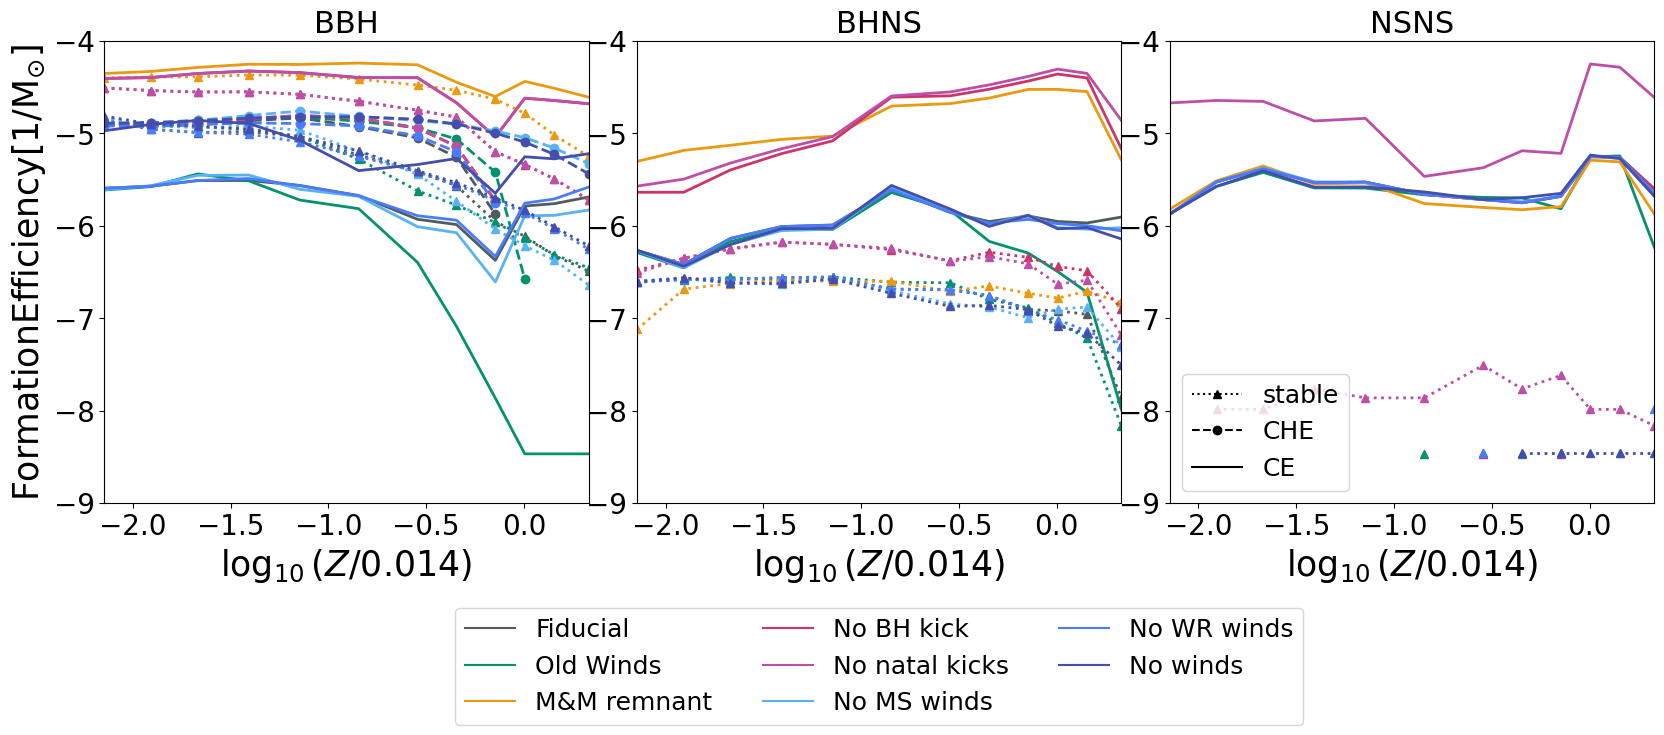

In [27]:
###########################################
# Create a figure
fig = plt.figure(figsize=(20, 6))

# Create a GridSpec with 1 row and 3 columns
gs      = GridSpec(1, 3, figure=fig)
axes    = [fig.add_subplot(gs[0, i]) for i in range(3)] # Create 3 subplots on a line

# List of panda tables of DCO mergers
DCO_flavors         = ["BBH", "BHNS", "NSNS"]

# sim_names = ['OldWinds_RemFryer2012', 'NewWinds_RemFryer2012', 'NewWinds_RemMullerMandel', 'NewWinds_RemFryer2012_noBHkick', 'NewWinds_RemFryer2012_noNSBHkick', \
    # 'NewWinds_RemFryer2012_noWRwinds','NewWinds_RemFryer2012_strongWRwinds', 'NewWinds_RemFryer2012_noMSwinds', 'RemFryer2012_NOwinds']
# Dictionary to map simulation names to labels and colors we want to use in the plots
sim_name_dict = {
    'NewWinds_RemFryer2012': ['Fiducial', '#515C5D'], 
    'OldWinds_RemFryer2012': ['Old Winds', '#02926C'],
    'NewWinds_RemMullerMandel': ['M&M remnant', '#EB9910'],
    'NewWinds_RemFryer2012_noBHkick': ['No BH kick', '#CE336A'],
    'NewWinds_RemFryer2012_noNSBHkick': ['No natal kicks', '#BE4EA8'],
    'NewWinds_RemFryer2012_noMSwinds': ['No MS winds', '#58B3F6'],
    'NewWinds_RemFryer2012_noWRwinds': ['No WR winds', '#497CFE'],
    'RemFryer2012_NOwinds': ['No winds', '#444EAC']
    }

# get a list of colors
cmap = mpl.colormaps['rainbow']
colors = cmap(np.linspace(0, 1, len(sim_name_dict.keys()) ) )


#########################
# For 
sim_plot_lines = [] # list to store the lines that will be added to the simulation legend
for sim_name, (label, color) in sim_name_dict.items():    
    try:
        merging_DCO_tables  = get_merging_dcos(sim_name =  sim_name, prog_table_name = 'potential_DCO_progenitors_Allinfo.h5')
    except:
        print(f"Error reading in {sim_name}, you might not have runt this sim yet?")
        continue

    totalMassEvolvedPerMetallicity = totalMassEvolvedPerZ(f'{datar_root}/{sim_name}/COMPAS_Output_combinedZ.h5', sampleSize=2000000)

    # Create the lines that will be added to the first legend
    sim_plot_lines.append(mlines.Line2D([], [], color=color, label= label))

    #########################
    # Loop over the axes and DCO flavors
    for ax, table, flavor in zip(axes, merging_DCO_tables, DCO_flavors):
        print(flavor)

        # Group by metallicity
        grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

        # Get all Z values and group lengths
        Z_values = np.array([Z for Z, group in grouped_byZ])

        # Check if weighted samples
        boolWeighted = 'mixture_weight' in table.keys()

        if boolWeighted: #UNTESTED
            print('using weighted samples')
            # sum the mixture_weight column for all, CE and stable channel
            All_group_lengths       = [sum(group['mixture_weight']) for Z, group in grouped_byZ]
            stable_group_lengths    = [sum(group['mixture_weight'][group['CE_Event_Counter'] == 0]) for Z, group in grouped_byZ]
            CE_group_lengths        = [sum(group['mixture_weight'][group['CE_Event_Counter'] > 0]) for Z, group in grouped_byZ]
            

        else:
            # count the number of systems in each group for all, CE and stable channel
            All_group_lengths       = [len(group) for Z, group in grouped_byZ]
            # Stable and non CHE
            stable_group_lengths    = [len(group[np.logical_and(group['CE_Event_Counter'] == 0, group['CH_on_MS(1)'] == 0) ]) for Z, group in grouped_byZ]
            # stable and CHE
            CHEstable_group_lengths    = [len(group[np.logical_and(group['CE_Event_Counter'] == 0, group['CH_on_MS(1)'] == 1 ) ]) for Z, group in grouped_byZ]

            # CE and non CHE
            CE_group_lengths        = [len(group[np.logical_and(group['CE_Event_Counter'] > 0, group['CH_on_MS(1)'] == 0) ]) for Z, group in grouped_byZ]
            # CE and CHE
            # CHECE_group_lengths        = [len(group[np.logical_and(group['CE_Event_Counter'] > 0, group['CH_on_MS(1)'] == 1) ]) for Z, group in grouped_byZ]

        print('Number of CHE BBH megers at different Z', CHEstable_group_lengths) #does this match the number of ZAMS mergers we see in the merger table? 
        print('Number of stable BBH megers at different Z', stable_group_lengths) #does this match the number of ZAMS mergers we see in the merger table? 
        print('Number of common env BBH megers at different Z', CE_group_lengths) #does this match the number of ZAMS mergers we see in the merger table? 

        # Plot the number of DCO mergers as a function of metallicity
        ax.plot(np.log10(Z_values/0.014), np.log10(stable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = ':', marker = '^', color = color)
        ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)

        ax.plot(np.log10(Z_values/0.014), np.log10(CE_group_lengths/totalMassEvolvedPerMetallicity), label = None, lw = 2, ls = '-',  color = color)
        # ax.plot(np.log10(Z_values/0.014), np.log10(CHECE_group_lengths/totalMassEvolvedPerMetallicity), label = f'Chem Hom. CE {sim_name}', lw = 2, ls = '--', marker = 'o', color = color)

        #####
        # plotvalues
        ax.set_title(f'{flavor}', fontsize = 22)

        ax.set_xlim(np.log10(1e-4/0.014),np.log10(0.03/0.014))
        ax.set_xlabel('$\log_{10}(Z/0.014)$', fontsize = 25)
        # ax.set_yscale('log')
        # ax.set_ylim(1e-9,5e-4)
        ax.set_ylim(-9,-4)
        ax.tick_params(axis='both', which='major', labelsize=20)     # increase  tick labels
        ax.tick_params(axis='both', which='minor', labelsize=20)
        

#########################
# plotvalues
fig.subplots_adjust(hspace=0.25, wspace=0.1)
axes[0].set_ylabel("$\mathrm{Formation Efficiency [1/M_{\odot}]}$", fontsize =25)

# Create the simulation legend
legend1 = axes[1].legend(handles= sim_plot_lines, bbox_to_anchor=(0.5, -0.2), loc='upper center', fontsize = 18, ncols = 3)

# Creating the channel legend
stable_line = mlines.Line2D([], [], color='black', linestyle=':', marker = '^', label='stable')
CHE_line    = mlines.Line2D([], [], color='black', linestyle='--', marker = 'o', label='CHE')
CE_line     = mlines.Line2D([], [], color='black', linestyle='-', label='CE')
axes[2].legend(handles=[stable_line, CHE_line, CE_line], loc='lower left', fontsize = 18)

plt.savefig(f'../plots/{compas_v}/Yield_variations.pdf', bbox_inches='tight')
plt.show()


('NewWinds_RemFryer2012', ['Fiducial', '#515C5D'], [<Axes: >, <Axes: >, <Axes: >], [])
('OldWinds_RemFryer2012', ['Old Winds', '#02926C'], [<Axes: >, <Axes: >, <Axes: >], [])
Table exists, reading in... 
Table exists, reading in... 
using discrete metallicities
using discrete metallicities
BBH
Number of CHE BBH megers at different Z [3519, 3480, 3597, 3984, 4271, 3442, 2595, 1605, 390, 0, 0, 0]
Number of stable BBH megers at different Z [3995, 3221, 2972, 3051, 2668, 1697, 1114, 789, 323, 224, 139, 94]
Number of common env BBH megers at different Z [741, 779, 897, 900, 795, 618, 342, 300, 123, 476, 505, 596]


/tmp/ipykernel_3307013/2764545352.py:60: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)


BHNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [71, 77, 76, 80, 81, 60, 59, 51, 36, 35, 32, 4]
Number of common env BBH megers at different Z [157, 111, 212, 285, 296, 714, 406, 323, 372, 324, 312, 362]


/tmp/ipykernel_3307013/2764545352.py:60: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)


NSNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
Number of common env BBH megers at different Z [388, 868, 1207, 855, 864, 636, 560, 517, 606, 1633, 1601, 729]


/tmp/ipykernel_3307013/2764545352.py:59: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(stable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = ':', marker = '^', color = color)
/tmp/ipykernel_3307013/2764545352.py:60: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)


BBH
Number of CHE BBH megers at different Z [3757, 3817, 4053, 4317, 4411, 3978, 3383, 2556, 1116, 78, 0, 0]
Number of stable BBH megers at different Z [4284, 3515, 3463, 3248, 2716, 1548, 702, 492, 319, 217, 143, 103]
Number of common env BBH megers at different Z [716, 780, 1070, 901, 558, 450, 118, 24, 4, 1, 1, 1]


/tmp/ipykernel_3307013/2764545352.py:60: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)


BHNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [75, 76, 81, 75, 82, 72, 71, 47, 38, 26, 18, 2]
Number of common env BBH megers at different Z [151, 103, 198, 270, 268, 674, 431, 199, 149, 94, 56, 3]


/tmp/ipykernel_3307013/2764545352.py:60: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)


NSNS
Number of CHE BBH megers at different Z [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of stable BBH megers at different Z [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Number of common env BBH megers at different Z [397, 784, 1112, 755, 752, 636, 596, 588, 449, 1635, 1677, 173]


/tmp/ipykernel_3307013/2764545352.py:59: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(stable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = ':', marker = '^', color = color)
/tmp/ipykernel_3307013/2764545352.py:60: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)


results [([<matplotlib.lines.Line2D object at 0x15542d3d7130>], [<Axes: title={'center': 'BBH'}, xlabel='$\\log_{10}(Z/0.014)$'>, <Axes: title={'center': 'BHNS'}, xlabel='$\\log_{10}(Z/0.014)$'>, <Axes: title={'center': 'NSNS'}, xlabel='$\\log_{10}(Z/0.014)$'>]), ([<matplotlib.lines.Line2D object at 0x15542d3d7370>], [<Axes: title={'center': 'BBH'}, xlabel='$\\log_{10}(Z/0.014)$'>, <Axes: title={'center': 'BHNS'}, xlabel='$\\log_{10}(Z/0.014)$'>, <Axes: title={'center': 'NSNS'}, xlabel='$\\log_{10}(Z/0.014)$'>])]


AttributeError: 'list' object has no attribute 'get_label'

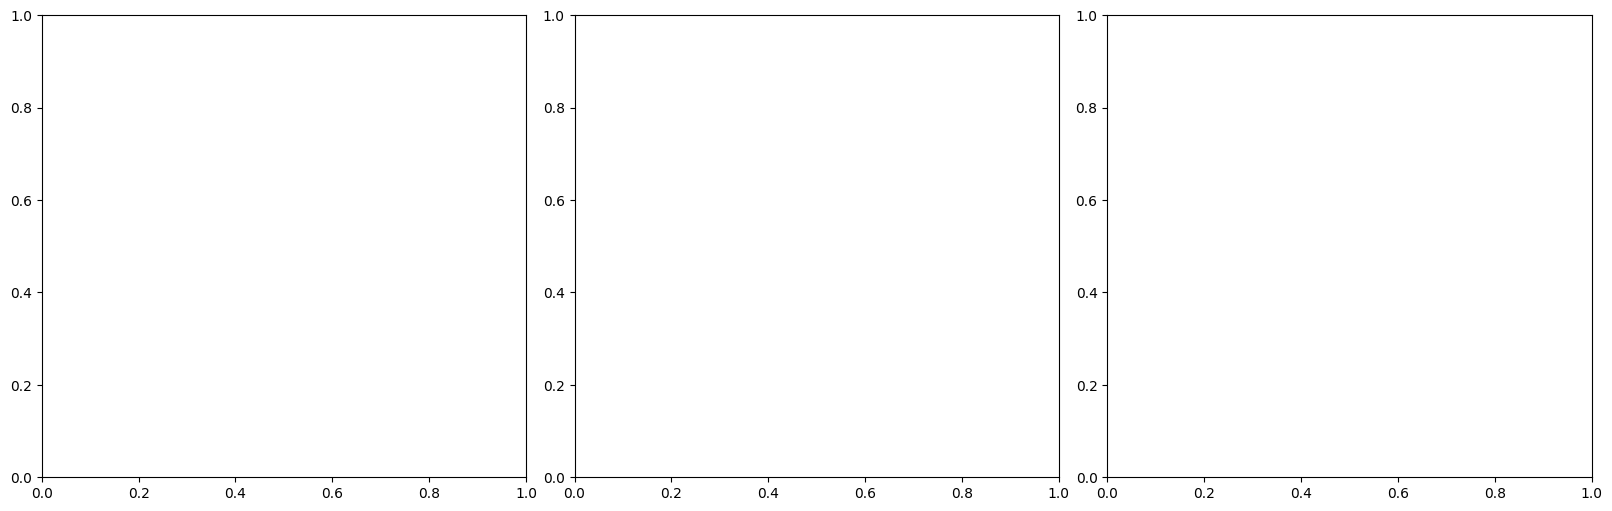

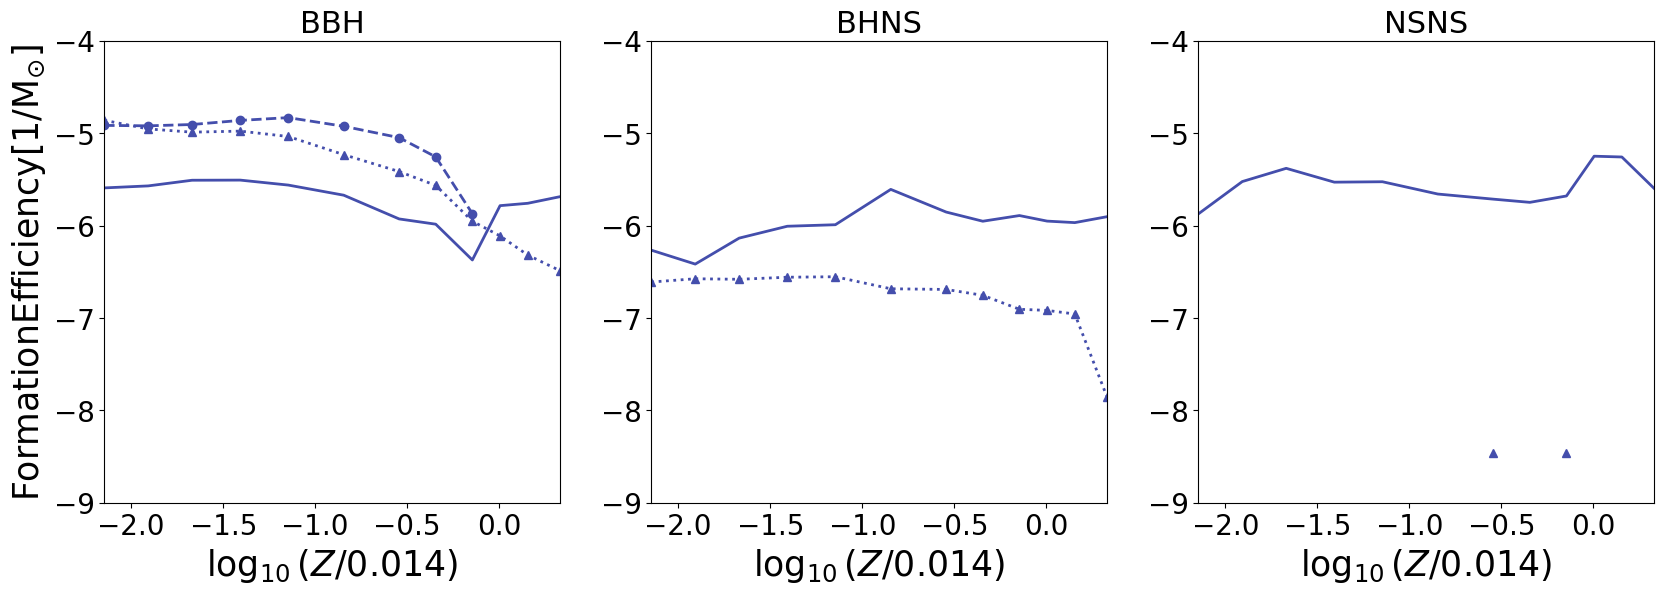

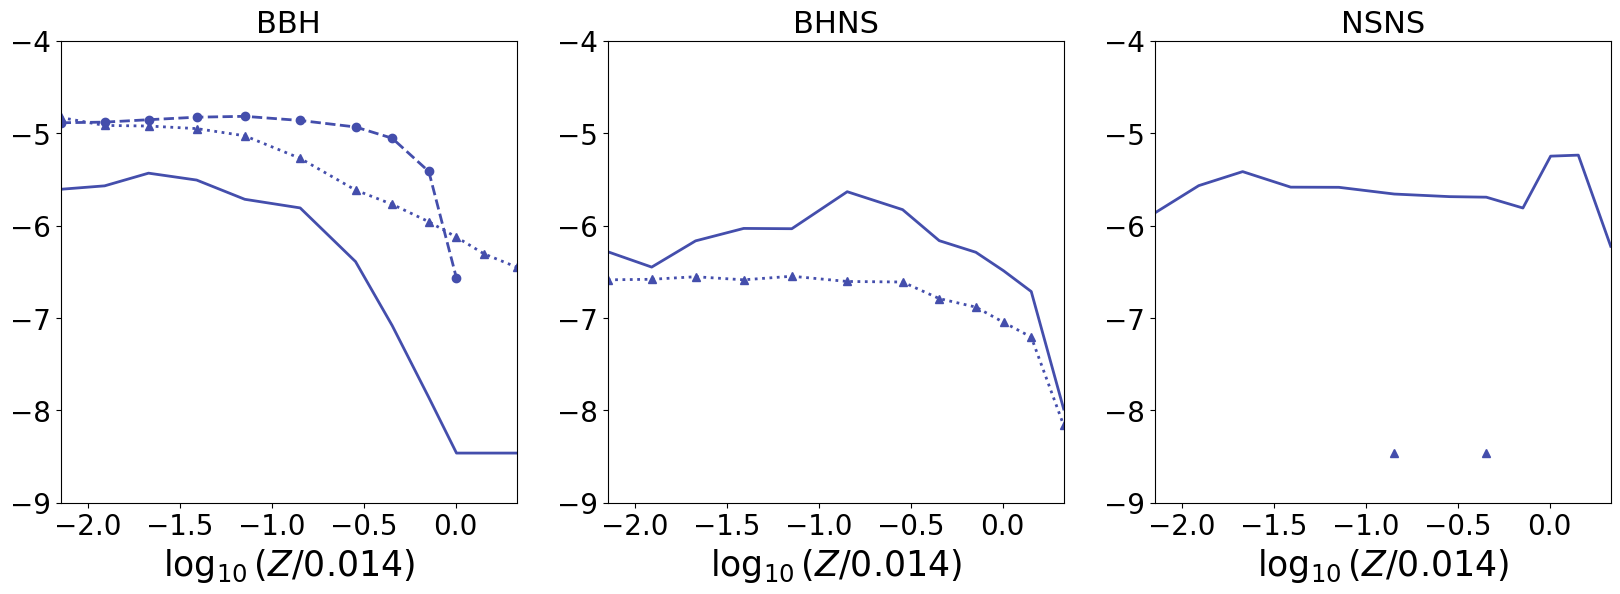

In [34]:
###########################################
###########################################
def read_and_plot_DCO_yield(sim_name_attributes_axes):
    print(sim_name_attributes_axes )
    # sim_name, attributes, axes, sim_plot_lines = sim_name_attributes_axes
    sim_name, attributes, axes, plot_lines = sim_name_attributes_axes
    try:
        merging_DCO_tables  = get_merging_dcos(sim_name =  sim_name, prog_table_name = 'potential_DCO_progenitors_Allinfo.h5')
    except:
        print(f"Error reading in {sim_name}, you might not have runt this sim yet?")
        return None

    totalMassEvolvedPerMetallicity = totalMassEvolvedPerZ(f'{datar_root}/{sim_name}/COMPAS_Output_combinedZ.h5', sampleSize=2000000)

    # Create the lines that will be added to the first legend
    # sim_plot_lines.append(mlines.Line2D([], [], color=color, label=sim_name_dict[sim_name] ))
    plot_lines.append(mlines.Line2D([], [], color=color, label=sim_name_dict[sim_name] ))

    #########################
    # Loop over the axes and DCO flavors
    for ax, table, flavor in zip(axes, merging_DCO_tables, DCO_flavors):
        print(flavor)

        # Group by metallicity
        grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

        # Get all Z values and group lengths
        Z_values = np.array([Z for Z, group in grouped_byZ])

        # Check if weighted samples
        boolWeighted = 'mixture_weight' in table.keys()

        if boolWeighted: #UNTESTED
            print('using weighted samples')
            # sum the mixture_weight column for all, CE and stable channel
            All_group_lengths       = [sum(group['mixture_weight']) for Z, group in grouped_byZ]
            stable_group_lengths    = [sum(group['mixture_weight'][group['CE_Event_Counter'] == 0]) for Z, group in grouped_byZ]
            CE_group_lengths        = [sum(group['mixture_weight'][group['CE_Event_Counter'] > 0]) for Z, group in grouped_byZ]
            

        else:
            # count the number of systems in each group for all, CE and stable channel
            All_group_lengths       = [len(group) for Z, group in grouped_byZ]
            # Stable and non CHE
            stable_group_lengths    = [len(group[np.logical_and(group['CE_Event_Counter'] == 0, group['CH_on_MS(1)'] == 0) ]) for Z, group in grouped_byZ]
            # stable and CHE
            CHEstable_group_lengths = [len(group[np.logical_and(group['CE_Event_Counter'] == 0, group['CH_on_MS(1)'] == 1 ) ]) for Z, group in grouped_byZ]

            # CE and non CHE
            CE_group_lengths        = [len(group[np.logical_and(group['CE_Event_Counter'] > 0, group['CH_on_MS(1)'] == 0) ]) for Z, group in grouped_byZ]
            # CE and CHE
            # CHECE_group_lengths        = [len(group[np.logical_and(group['CE_Event_Counter'] > 0, group['CH_on_MS(1)'] == 1) ]) for Z, group in grouped_byZ]

        print('Number of CHE BBH megers at different Z', CHEstable_group_lengths) #does this match the number of ZAMS mergers we see in the merger table? 
        print('Number of stable BBH megers at different Z', stable_group_lengths) #does this match the number of ZAMS mergers we see in the merger table? 
        print('Number of common env BBH megers at different Z', CE_group_lengths) #does this match the number of ZAMS mergers we see in the merger table? 

        # Plot the number of DCO mergers as a function of metallicity
        ax.plot(np.log10(Z_values/0.014), np.log10(stable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = ':', marker = '^', color = color)
        ax.plot(np.log10(Z_values/0.014), np.log10(CHEstable_group_lengths/totalMassEvolvedPerMetallicity), label = None , lw = 2, ls = '--', marker = 'o', color = color)

        ax.plot(np.log10(Z_values/0.014), np.log10(CE_group_lengths/totalMassEvolvedPerMetallicity), label = None, lw = 2, ls = '-',  color = color)
        # ax.plot(np.log10(Z_values/0.014), np.log10(CHECE_group_lengths/totalMassEvolvedPerMetallicity), label = f'Chem Hom. CE {sim_name}', lw = 2, ls = '--', marker = 'o', color = color)

        #####
        # plotvalues
        ax.set_title(f'{flavor}', fontsize = 22)

        ax.set_xlim(np.log10(1e-4/0.014),np.log10(0.03/0.014))
        ax.set_xlabel('$\log_{10}(Z/0.014)$', fontsize = 25)
        # ax.set_yscale('log')
        # ax.set_ylim(1e-9,5e-4)
        ax.set_ylim(-9,-4)
        ax.tick_params(axis='both', which='major', labelsize=20)     # increase  tick labels
        ax.tick_params(axis='both', which='minor', labelsize=20)


    return plot_lines, axes            


###########################################
###########################################
# Create a figure
fig = plt.figure(figsize=(20, 6))

# Create a GridSpec with 1 row and 3 columns
gs      = GridSpec(1, 3, figure=fig)
axes    = [fig.add_subplot(gs[0, i]) for i in range(3)] # Create 3 subplots on a line

# List of panda tables of DCO mergers
DCO_flavors         = ["BBH", "BHNS", "NSNS"]

# sim_names = ['OldWinds_RemFryer2012', 'NewWinds_RemFryer2012', 'NewWinds_RemMullerMandel', 'NewWinds_RemFryer2012_noBHkick', 'NewWinds_RemFryer2012_noNSBHkick', \
    # 'NewWinds_RemFryer2012_noWRwinds','NewWinds_RemFryer2012_strongWRwinds', 'NewWinds_RemFryer2012_noMSwinds', 'RemFryer2012_NOwinds']
# Dictionary to map simulation names to labels and colors we want to use in the plots
sim_name_dict = {
    'NewWinds_RemFryer2012': ['Fiducial', '#515C5D'], 
    'OldWinds_RemFryer2012': ['Old Winds', '#02926C'],
    # 'NewWinds_RemMullerMandel': ['M&M remnant', '#EB9910'],
    # 'NewWinds_RemFryer2012_noBHkick': ['No BH kick', '#CE336A'],
    # 'NewWinds_RemFryer2012_noNSBHkick': ['No natal kicks', '#BE4EA8'],
    # 'NewWinds_RemFryer2012_noMSwinds': ['No MS winds', '#58B3F6'],
    # 'NewWinds_RemFryer2012_noWRwinds': ['No WR winds', '#497CFE'],
    # 'RemFryer2012_NOwinds': ['No winds', '#444EAC']
    }

# get a list of colors
cmap = mpl.colormaps['rainbow']
colors = cmap(np.linspace(0, 1, len(sim_name_dict.keys()) ) )

plot_lines = [] # list to store the lines that will be added to the simulation legend

#########################
# divide the plotting over multiple cores
pool = mp.Pool(mp.cpu_count())
results = pool.map(read_and_plot_DCO_yield, [(sim_name, attributes, axes, plot_lines) for sim_name, attributes in sim_name_dict.items()])
pool.close()

# results now contains a list of lines, and a list of axes for each simulation

results [([<matplotlib.lines.Line2D object at 0x15542d3d7130>], [<Axes: title={'center': 'BBH'}, xlabel='$\\log_{10}(Z/0.014)$'>, <Axes: title={'center': 'BHNS'}, xlabel='$\\log_{10}(Z/0.014)$'>, <Axes: title={'center': 'NSNS'}, xlabel='$\\log_{10}(Z/0.014)$'>]),
 ([<matplotlib.lines.Line2D object at 0x15542d3d7370>],[<Axes: title={'center': 'BBH'}, xlabel='$\\log_{10}(Z/0.014)$'>, <Axes: title={'center': 'BHNS'}, xlabel='$\\log_{10}(Z/0.014)$'>, <Axes: title={'center': 'NSNS'}, xlabel='$\\log_{10}(Z/0.014)$'>])]

print('results', results)
sim_plot_lines = [res[0] for res in results] # list to store the lines that will be added to the simulation legend
axes = results[0][1] # get the modified axes list from the first result

#########################
# plotvalues
fig.subplots_adjust(hspace=0.25, wspace=0.1)
axes[0].set_ylabel("$\mathrm{Formation Efficiency [1/M_{\odot}]}$", fontsize =25)

# Create the simulation legend
legend1 = axes[1].legend(handles= sim_plot_lines, bbox_to_anchor=(0.5, -0.2), loc='upper center', fontsize = 18, ncols = 3)

# Creating the channel legend
stable_line = mlines.Line2D([], [], color='black', linestyle=':', marker = '^', label='stable')
CHE_line    = mlines.Line2D([], [], color='black', linestyle='--', marker = 'o', label='CHE')
CE_line     = mlines.Line2D([], [], color='black', linestyle='-', label='CE')
axes[2].legend(handles=[stable_line, CHE_line, CE_line], loc='lower left', fontsize = 18)

plt.savefig(f'../plots/{compas_v}/Yield_variations.pdf', bbox_inches='tight')
plt.show()
